<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Experiments" data-toc-modified-id="Experiments-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Experiments</a></span></li><li><span><a href="#Deliverables" data-toc-modified-id="Deliverables-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Deliverables</a></span></li></ul></li><li><span><a href="#Code" data-toc-modified-id="Code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Replace-with-Mode" data-toc-modified-id="Replace-with-Mode-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Replace with Mode</a></span></li></ul></li><li><span><a href="#Remove-'-?'-in-workclass,-occupation,-native-country" data-toc-modified-id="Remove-'-?'-in-workclass,-occupation,-native-country-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Remove ' ?' in workclass, occupation, native-country</a></span></li><li><span><a href="#Convert-Discrete-to-OneHot" data-toc-modified-id="Convert-Discrete-to-OneHot-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Convert Discrete to OneHot</a></span></li><li><span><a href="#KNN-Classifiers" data-toc-modified-id="KNN-Classifiers-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>KNN Classifiers</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li></ul></li></ul></div>

## Preprocessing
Your first task is to acquire the data, analyze it, and clean it (if necessary).  You will use two datasets in this project,outlined below.
• Dataset 1 (Adult dataset): This dataset presents several attributes of different individuals and the predictiontask is to determine whether someone makes over 50K a year.  Download and read information about the datasethere.

The essential subtasks for this part of the project include:

1.  Download the datasets.Hints: For clarity, in the Adult dataset, adult.data contains the training/validation dataand adult.test contains the test data.
2.  Load the datasets into Pandas dataframes or NumPy objects (i.e., arrays or matrices) in Python.
3.  Clean the data.  You should remove instances that have too many missing or invalid data entries.
4.  Convert discrete variables into multiple variables using one-hot encoding.  For an example on how to do this,check out ”Encoding categorical features” in the scikit-learn documentation.

## Experiments
In this part, you will compare two supervised learning frameworks, namelyK-nearest neighbours(KNN) anddecisiontrees,  to predict whether the income of an adult exceeds $50K/yr.  A similar analysis should be performed for thesecond dataset.  The specific subtasks for this part include:
1.  Implement and perform 5-fold cross validation on the training/validation data (for theAdultdataset, this datais contained in theadult.datafile) to optimize hyperparameters for both models.Your implementation forcross-validation should be from scratch.  You should not use existing packages for cross validation.Report the mean of the training and validation metrics for the given hyperparameters.
2.  Sample growing subsets of the training/validation data and repeat step 1.  We want to understand how the sizeof a dataset impacts both the training and validation error.
3.  Take the best performing model (the one with the best performance on 5-fold cross validation) and apply it onthe test set (in theAdultdataset, this is theadult.testfile).  This is an unbiased estimate of how your modelwould perform on new/unseen data.
4.  [Optional] Go above and beyond!  Examples:  different normalization techniques or other ways of handling of missing data (search “data imputation” techniques).  Employ more sophisticated techniques for hyper-parameter search.  Engineering new features out of existing ones to get a better performance.  Investigate which featuresare the most useful (e.g., by correlating them with your predictions or removing them from your data)?
5.  Analyze your findings; how did the choice of the various hyper-parameters impact generalization?  How aboutthe size of training data?  If any of these findings do not agree with your expectation, you can form hypothesesand further investigate them.

## Deliverables
You must submit two separate files to MyCourses(using the exact filenames and file types outlined below):

1. code.zip:  Your  entire  code,  which  should  consist  of  a  jupyter  notebook  file  (.ipynb),  and  additional  pythonfiles (.py);the notebook should contain the main body of your code, where we can see and easily reproduce the plots in your report.
2. writeup.pdf:  Your (max three pages) project write-up as a pdf (details below).

# Code

### Step 1: Download the datasets.Hints: For clarity, in the Adult dataset, adult.data contains the training/validation data and adult.test contains the test data.

In [58]:
from utils import *
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time

In [187]:
# TODO Put in .py
rootdir = 'Adult dataset'
 
adult_names = ["age",
"workclass",
"fnlwgt",
"education",
"education-num",
"marital-status",
"occupation",
"relationship",
"race",
"sex",
"capital-gain",
"capital-loss",
"hours-per-week",
"native-country"]

def load_adult(adult_names, rootdir=rootdir, split='train'):
    csv_name = 'adult.data' if split == 'train' else 'adult.test'
    csv_path = os.path.join(rootdir, csv_name)
    assert os.path.exists(csv_path), f"{csv_path} does not exist"
    adult_data = pd.read_csv(csv_path, names=adult_names + ['salary'], index_col=False)
    return adult_data

def get_faulty_col_names(df):
    faulty_cols = []
    
#     Check NA values
    for col_name in df.columns.tolist():
        if df[col_name].isna().values.any() is True:
            faulty_cols.append(col_name)

#     Check for ' ?'
        if ' ?' in df[col_name].unique().tolist():
            if col_name not in faulty_cols:
                faulty_cols.append(col_name)
            print(f"Number of ' ?' in {col_name}: {df[col_name].value_counts()[' ?']}")
    
    return faulty_cols

def replace_with_mode(df, faulty_cols):
    
    df_without_QM = df.copy()
    for col in faulty_cols:
        df_without_QM = df_without_QM[getattr(df, col) != ' ?']
    
    r_df = df.copy()
    mapping = {}
    for col in faulty_cols:
        mapping[col] = df_without_QM[col].mode().values[0]
        r_df[col] = r_df[col].replace(' ?', mapping[col])
    return r_df, mapping

def replace_with_mapping(df, faulty_cols, mapping):
    r_df = df.copy()
    for col in faulty_cols:
        r_df[col] = r_df[col].replace(' ?', mapping[col])
    return r_df

def get_binary_labels_for_salary(df):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    assert isinstance(df, pd.DataFrame)
    salary_map = {' <=50K': 0, ' <=50K.': 0, ' >50K': 1, ' >50K.': 1}
    df['salary'] = df['salary'].map(salary_map)
    
    return df['salary'].tolist()

def generate_cross_validation(n_folds, X, y):
    samples = len(X)
    elements_in_fold = samples // n_folds
    indices = [0]
    while indices[-1] + elements_in_fold <= samples - samples % n_folds:
        indices.append(indices[-1] + elements_in_fold)
    indices[-1] = samples
    cross_val_sets = [[indices[i], indices[i+1]] for i in range(len(indices)-1)]
    for val_set in cross_val_sets:
        begin, end = val_set[0], val_set[1]
        train_X_fold = X[0:begin].append(X[end:])
        validation_X_fold = X[begin:end]
        train_y_fold = y[0:begin] + y[end:]
        validation_y_fold = y[begin:end]
        yield train_X_fold, train_y_fold, validation_X_fold, validation_y_fold

def knn_fit(X_train, y_train, X_val, y_val, one_hot, knn=3):
    neigh = KNeighborsClassifier(n_neighbors=knn)
    neigh.fit(one_hot.transform(X_train), y_train)
    pred_y = neigh.predict(OH_enc.transform(X_val))
    acc = get_accuracy(y_val, pred_y)
    return neigh, acc

def eval_classifier(X, y, one_hot, classifier):
    pred_y = classifier.predict(one_hot.transform(X))
    acc = get_accuracy(y, pred_y)
    return acc

def fit_classifier(X_train, y_train, one_hot, classifier_model, **kwargs):
    classifier = classifier_model(**kwargs)
    classifier.fit(one_hot.fit_transform(X_train), y_train)
    return classifier, one_hot

def get_accuracy(y_label, y_pred):
    assert len(y_label) == len(y_pred)
    acc = 100 * sum(y_label == y_pred) / len(y_label)
    return acc

In [188]:
# Vars 
data_rootdir = 'Adult dataset'

# For step 3: data cleaning
remove_dup = True
clean_data = 'replace' # 'remove' missing data entries; 'replace' missing data entries with the mode; 'knn_impute' missing data entries

### Step 2: Load the datasets into Pandas dataframes or NumPy objects (i.e., arrays or matrices) in Python.

In [61]:
df = load_adult(adult_names, data_rootdir)

### Step 3: Clean the data.  You should remove instances that have too many missing or invalid data entries

Faulty column values can be: 
1. Replaced with mode
2. KNN imputed
3. Removed

In our dataset, the faulty data entries have value ' :?'

In [62]:
if remove_dup is True:
    df = df.drop_duplicates()

# Get faulty columns in the df - ones with na values or ' :?' values
faulty_cols = get_faulty_col_names(df)
print(faulty_cols)

if clean_data == 'remove':
    for col in faulty_cols:
        clean_train_df = df[getattr(df, col) != ' ?']
    
elif clean_data == 'replace':
    clean_train_df, mode_mapping = replace_with_mode(df, faulty_cols)

elif clean_data == 'knn_impute':
    # TODO
    pass

assert get_faulty_col_names(clean_train_df) == []
print(len(clean_train_df))
df.head()

Number of ' ?' in workclass: 1836
Number of ' ?' in occupation: 1843
Number of ' ?' in native-country: 582
['workclass', 'occupation', 'native-country']
32537


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Step 4: Convert discrete variables into multiple variables using one-hot encoding.  For an example on how to do this, check out ”Encoding categorical features” in the scikit-learn documentation.

In [63]:
# Split data into input columns and labels
X_train, y_train = clean_train_df.drop('salary', axis=1), get_binary_labels_for_salary(clean_train_df['salary'])

# Get categorical variables of data
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Discrete Variables: ", cat_cols)

# Convert discrete variables into multiple variables using one-hot encoder and fit
from sklearn.preprocessing import OneHotEncoder
OH_enc = OneHotEncoder(handle_unknown='ignore')
OH_enc.fit(X_train)

Discrete Variables:  ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [64]:
print("After converting discrete variables into multiple variables")
OH_enc.transform(X_train)

After converting discrete variables into multiple variables


<32537x22141 sparse matrix of type '<class 'numpy.float64'>'
	with 455518 stored elements in Compressed Sparse Row format>

## Experiments

### Exp 1:  Implement and perform 5-fold cross validation on the training/validation data (for the Adult dataset, this data is contained in the adult.datafile) to optimize hyperparameters for both models.Your implementation for cross-validation should be from scratch.  You should not use existing packages for cross validation. Report the mean of the training and validation metrics for the given hyperparameters.

Our implementation of K-Fold Cross Validation is at <b>utils.py</b> named as <b>generate_cross_validation</b>

### KNN hyperparameters

Hyperparameters
- `n_neighbors` : [2:10:2]
- `p`: [1:2:1]

In [86]:
# KNN Hyperparams
n_neighbors = [2, 4, 6]  # Number of neighbors for KNN
p = [1, 2]            # Power parameter for the Minkowski metric

In [87]:
n_folds = 5
knn_models, knn_train_accs, knn_val_accs = [], [], []

for n_neigh in tqdm(n_neighbors, total=len(n_neighbors)):
    for _p in tqdm(p, total=len(p)):
        knn_kw = {
            'n_neighbors': n_neigh,
            'p': _p,
        }
        models, train_accs, val_accs = [], [], []
        
        for batch in tqdm(generate_cross_validation(n_folds, X_train, y_train), total=n_folds):
            cross_X_train, cross_y_train, cross_X_val, cross_y_val = batch
    
            knn_model, one_hot = fit_classifier(cross_X_train, cross_y_train, OneHotEncoder(handle_unknown='ignore'), KNeighborsClassifier, **knn_kw)
    
            train_acc = eval_classifier(cross_X_train, cross_y_train, one_hot, knn_model)
            val_acc = eval_classifier(cross_X_val, cross_y_val, one_hot, knn_model)
            
            models.append(knn_model)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
        print(f"Num neighbors: {n_neigh} | p: {_p}")
        print("Train Accuracies on 5-fold CV:", train_accs)
        print("Validation Accuracies on 5-fold CV:", val_accs)
        print("Mean train accuracy: ", np.mean(train_accs))
        print("Mean validation accuracy: ", np.mean(val_accs))
        print()
            
        knn_models.append(models)
        knn_train_accs.append(train_accs)
        knn_val_accs.append(val_accs)


Num neighbors: 2 | p: 1
Train Accuracies on 5-fold CV: [88.93584325777948, 88.8743757203227, 88.97041874759893, 88.98194391087208, 89.00414937759336]
Validation Accuracies on 5-fold CV: [80.69771015829107, 80.75918241893346, 80.72844628861226, 80.86675887505763, 80.47319096635428]
Mean train accuracy:  88.95334620283332
Mean validation accuracy:  80.70505774144974




Num neighbors: 2 | p: 2
Train Accuracies on 5-fold CV: [88.93584325777948, 88.8743757203227, 88.97041874759893, 88.98194391087208, 89.00414937759336]
Validation Accuracies on 5-fold CV: [80.69771015829107, 80.75918241893346, 80.72844628861226, 80.86675887505763, 80.47319096635428]
Mean train accuracy:  88.95334620283332
Mean validation accuracy:  80.70505774144974





Num neighbors: 4 | p: 1
Train Accuracies on 5-fold CV: [87.17633499807914, 87.10718401844026, 87.21859393008067, 87.18401844026124, 87.22529583525434]
Validation Accuracies on 5-fold CV: [81.97325956662056, 81.57368987244506, 82.32672506531428, 82.01936376210236, 81.48717160854201]
Mean train accuracy:  87.18228544442313
Mean validation accuracy:  81.87604197500484




Num neighbors: 4 | p: 2
Train Accuracies on 5-fold CV: [87.17633499807914, 87.10718401844026, 87.21859393008067, 87.18401844026124, 87.22529583525434]
Validation Accuracies on 5-fold CV: [81.97325956662056, 81.57368987244506, 82.32672506531428, 82.01936376210236, 81.48717160854201]
Mean train accuracy:  87.18228544442313
Mean validation accuracy:  81.87604197500484





Num neighbors: 6 | p: 1
Train Accuracies on 5-fold CV: [86.42335766423358, 86.42335766423358, 86.3311563580484, 86.34268152132155, 86.3685262025511]
Validation Accuracies on 5-fold CV: [82.08083602274473, 82.38819732595667, 82.32672506531428, 82.49577378208083, 82.0863419880166]
Mean train accuracy:  86.37781588207764
Mean validation accuracy:  82.27557483682263




Num neighbors: 6 | p: 2
Train Accuracies on 5-fold CV: [86.42335766423358, 86.42335766423358, 86.3311563580484, 86.34268152132155, 86.3685262025511]
Validation Accuracies on 5-fold CV: [82.08083602274473, 82.38819732595667, 82.32672506531428, 82.49577378208083, 82.0863419880166]
Mean train accuracy:  86.37781588207764
Mean validation accuracy:  82.27557483682263





### Decision tree hyperparameters

Hyperparameters
- `criterion`: ['gini', 'entropy']
- `max_depth`: [5:20:5]
- `min_samples_split`: [2:6:2]

In [111]:
# Decision Trees Hyperparams
criterion = ['entropy', 'gini']
max_depth = [5, 10, 15, 20]
min_samples_split = [2, 4, 6]

In [112]:
n_folds = 5
dt_models, dt_train_accs, dt_val_accs = [], [], []

for criteria in criterion:
    for depth in max_depth:
        for mss in min_samples_split:
            dt_kw = {
                'criterion': criteria,
                'max_depth': depth,
                'min_samples_split': mss
            }
            models, train_accs, val_accs = [], [], []

            for batch in tqdm(generate_cross_validation(n_folds, X_train, y_train), total=n_folds):
                cross_X_train, cross_y_train, cross_X_val, cross_y_val = batch
    
                dt_model, one_hot = fit_classifier(cross_X_train, cross_y_train, OneHotEncoder(handle_unknown='ignore'), DecisionTreeClassifier, **dt_kw)
    
                train_acc = eval_classifier(cross_X_train, cross_y_train, one_hot, dt_model)
                val_acc = eval_classifier(cross_X_val, cross_y_val, one_hot, dt_model)
            
                models.append(knn_model)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
            
            print(f"Criteria: {criteria} | depth: {depth} | min_sample_split: {mss}")
            print("Train Accuracies on 5-fold CV:", train_accs)
            print("Validation Accuracies on 5-fold CV:", val_accs)
            print("Mean train accuracy: ", np.mean(train_accs))
            print("Mean validation accuracy: ", np.mean(val_accs))
            print()
            
            dt_models.append(models)
            dt_train_accs.append(train_accs)
            dt_val_accs.append(val_accs)



Criteria: entropy | depth: 5 | min_sample_split: 2
Train Accuracies on 5-fold CV: [82.80829811755666, 82.66615443718786, 82.71993853246255, 82.59700345754898, 82.68403258029814]
Validation Accuracies on 5-fold CV: [82.28062086983249, 82.29598893499309, 82.55724604272322, 82.72629475948978, 82.3936088492856]
Mean train accuracy:  82.69508542501083
Mean validation accuracy:  82.45075189126484




Criteria: entropy | depth: 5 | min_sample_split: 4
Train Accuracies on 5-fold CV: [82.80829811755666, 82.66615443718786, 82.7160968113715, 82.59700345754898, 82.68403258029814]
Validation Accuracies on 5-fold CV: [82.28062086983249, 82.29598893499309, 82.55724604272322, 82.69555862916859, 82.3936088492856]
Mean train accuracy:  82.69431708079263
Mean validation accuracy:  82.4446046652006




Criteria: entropy | depth: 5 | min_sample_split: 6
Train Accuracies on 5-fold CV: [82.80829811755666, 82.66615443718786, 82.7160968113715, 82.59700345754898, 82.68403258029814]
Validation Accuracies on 5-fold CV: [82.28062086983249, 82.29598893499309, 82.55724604272322, 82.69555862916859, 82.3936088492856]
Mean train accuracy:  82.69431708079263
Mean validation accuracy:  82.4446046652006




Criteria: entropy | depth: 10 | min_sample_split: 2
Train Accuracies on 5-fold CV: [86.26584709950058, 86.35804840568575, 86.09681137149443, 86.30042258932002, 86.28015982787767]
Validation Accuracies on 5-fold CV: [84.75487936068849, 85.16981712002459, 84.90856001229446, 85.44644229291532, 85.77354432324474]
Mean train accuracy:  86.26025785877569
Mean validation accuracy:  85.21064862183351




Criteria: entropy | depth: 10 | min_sample_split: 4
Train Accuracies on 5-fold CV: [86.26200537840953, 86.34268152132155, 86.08144448713024, 86.28505570495582, 86.28015982787767]
Validation Accuracies on 5-fold CV: [84.75487936068849, 85.16981712002459, 84.80098355617028, 85.43107422775472, 85.69672760792749]
Mean train accuracy:  86.25026938393896
Mean validation accuracy:  85.1706963745131




Criteria: entropy | depth: 10 | min_sample_split: 6
Train Accuracies on 5-fold CV: [86.2274298885901, 86.31963119477525, 86.03534383403765, 86.28121398386477, 86.26863377900722]
Validation Accuracies on 5-fold CV: [84.75487936068849, 85.20055325034578, 84.81635162133088, 85.44644229291532, 85.80427100937163]
Mean train accuracy:  86.226450536055
Mean validation accuracy:  85.20449950693042




Criteria: entropy | depth: 15 | min_sample_split: 2
Train Accuracies on 5-fold CV: [88.42489435267, 88.31348444102959, 88.5516711486746, 88.35574337303112, 88.38558475487936]
Validation Accuracies on 5-fold CV: [84.95466420777625, 85.50791455355771, 85.78453972644844, 85.67696327032426, 85.74281763711784]
Mean train accuracy:  88.40627561405692
Mean validation accuracy:  85.5333798790449




Criteria: entropy | depth: 15 | min_sample_split: 4
Train Accuracies on 5-fold CV: [88.36342681521322, 88.23280829811756, 88.44410295812524, 88.2597003457549, 88.40479483633011]
Validation Accuracies on 5-fold CV: [85.06224066390041, 85.44644229291532, 85.66159520516366, 85.64622714000308, 85.83499769549854]
Mean train accuracy:  88.3409666507082
Mean validation accuracy:  85.5303005994962




Criteria: entropy | depth: 15 | min_sample_split: 6
Train Accuracies on 5-fold CV: [88.28275067230119, 88.0945063388398, 88.29043411448329, 88.15981559738763, 88.27032426617488]
Validation Accuracies on 5-fold CV: [85.1083448593822, 85.56938681420009, 85.58475487936069, 85.5232826187183, 85.85036103856199]
Mean train accuracy:  88.21956619783737
Mean validation accuracy:  85.52722604204465




Criteria: entropy | depth: 20 | min_sample_split: 2
Train Accuracies on 5-fold CV: [90.10756819054937, 90.1421436803688, 90.1805608912793, 89.86169804072225, 89.98002151529123]
Validation Accuracies on 5-fold CV: [84.83171968649147, 85.5540187490395, 85.06224066390041, 85.81527585676963, 85.51236749116607]
Mean train accuracy:  90.0543984636422
Mean validation accuracy:  85.35512448947341




Criteria: entropy | depth: 20 | min_sample_split: 4
Train Accuracies on 5-fold CV: [90.02689204763735, 90.0153668843642, 90.01920860545525, 89.80023050326547, 89.86476102658675]
Validation Accuracies on 5-fold CV: [84.52435838327955, 85.5386506838789, 85.09297679422161, 85.67696327032426, 85.35873406053157]
Mean train accuracy:  89.94529181346181
Mean validation accuracy:  85.23833663844718




Criteria: entropy | depth: 20 | min_sample_split: 6
Train Accuracies on 5-fold CV: [89.75797157126392, 89.78870533999232, 89.77718017671917, 89.55436035343834, 89.6572921469187]
Validation Accuracies on 5-fold CV: [84.6934071000461, 85.43107422775472, 85.30812970646996, 85.73843553096665, 85.42018743278537]
Mean train accuracy:  89.7071019176665
Mean validation accuracy:  85.31824679960457




Criteria: gini | depth: 5 | min_sample_split: 2
Train Accuracies on 5-fold CV: [82.87360737610449, 82.96196696119861, 83.18478678447944, 83.15021129466001, 83.17581066543723]
Validation Accuracies on 5-fold CV: [82.37282926079607, 82.71092669432919, 83.29491317043184, 83.14123251882587, 82.83914579812567]
Mean train accuracy:  83.06927661637596
Mean validation accuracy:  82.87180948850173




Criteria: gini | depth: 5 | min_sample_split: 4
Train Accuracies on 5-fold CV: [82.87360737610449, 82.96196696119861, 83.18478678447944, 83.15021129466001, 83.17581066543723]
Validation Accuracies on 5-fold CV: [82.37282926079607, 82.71092669432919, 83.29491317043184, 83.17196864914708, 82.83914579812567]
Mean train accuracy:  83.06927661637596
Mean validation accuracy:  82.87795671456597




Criteria: gini | depth: 5 | min_sample_split: 6
Train Accuracies on 5-fold CV: [82.87360737610449, 82.96196696119861, 83.18478678447944, 83.15021129466001, 83.17581066543723]
Validation Accuracies on 5-fold CV: [82.37282926079607, 82.71092669432919, 83.29491317043184, 83.14123251882587, 82.83914579812567]
Mean train accuracy:  83.06927661637596
Mean validation accuracy:  82.87180948850173




Criteria: gini | depth: 10 | min_sample_split: 2
Train Accuracies on 5-fold CV: [86.37341529004995, 86.3695735689589, 86.0545524394929, 86.10449481367652, 86.11879514369141]
Validation Accuracies on 5-fold CV: [84.83171968649147, 84.97003227293683, 85.35423390195174, 85.23128938066698, 85.32800737440468]
Mean train accuracy:  86.20416625117393
Mean validation accuracy:  85.14305652329035




Criteria: gini | depth: 10 | min_sample_split: 4
Train Accuracies on 5-fold CV: [86.38109873223203, 86.36573184786785, 86.0391855551287, 86.09681137149443, 86.11111111111111]
Validation Accuracies on 5-fold CV: [84.87782388197326, 85.03150453357922, 85.36960196711235, 85.27739357614877, 85.26655400215087]
Mean train accuracy:  86.19878772356682
Mean validation accuracy:  85.16457559219289




Criteria: gini | depth: 10 | min_sample_split: 6
Train Accuracies on 5-fold CV: [86.35804840568575, 86.3465232424126, 86.0084517864003, 86.07376104494814, 86.08421699708006]
Validation Accuracies on 5-fold CV: [84.83171968649147, 85.04687259873982, 85.36960196711235, 85.21592131550638, 85.28191734521432]
Mean train accuracy:  86.17420029530538
Mean validation accuracy:  85.14920658261286




Criteria: gini | depth: 15 | min_sample_split: 2
Train Accuracies on 5-fold CV: [88.37111025739532, 88.4018440261237, 88.15213215520554, 87.95620437956204, 87.91301675119102]
Validation Accuracies on 5-fold CV: [85.30812970646996, 85.49254648839711, 85.81527585676963, 85.35423390195174, 85.34337071746812]
Mean train accuracy:  88.15886151389553
Mean validation accuracy:  85.4627113342113




Criteria: gini | depth: 15 | min_sample_split: 4
Train Accuracies on 5-fold CV: [88.33269304648482, 88.32116788321167, 88.13292354975029, 87.86400307337688, 87.85922852312893]
Validation Accuracies on 5-fold CV: [85.30812970646996, 85.61549100968188, 85.81527585676963, 85.43107422775472, 85.28191734521432]
Mean train accuracy:  88.10200321519052
Mean validation accuracy:  85.4903776291781




Criteria: gini | depth: 15 | min_sample_split: 6
Train Accuracies on 5-fold CV: [88.24049174029966, 88.20975797157126, 87.98309642719938, 87.79869381482904, 87.78623021361611]
Validation Accuracies on 5-fold CV: [85.33886583679114, 85.43107422775472, 85.78453972644844, 85.44644229291532, 85.45091411891228]
Mean train accuracy:  88.00365403350308
Mean validation accuracy:  85.49036724056438




Criteria: gini | depth: 20 | min_sample_split: 2
Train Accuracies on 5-fold CV: [90.04610065309258, 90.1421436803688, 90.16903572800615, 89.76949673453707, 89.74181650530198]
Validation Accuracies on 5-fold CV: [85.29276164130935, 85.67696327032426, 85.56938681420009, 85.75380359612724, 85.12828391457981]
Mean train accuracy:  89.97371866026133
Mean validation accuracy:  85.48423984730815




Criteria: gini | depth: 20 | min_sample_split: 4
Train Accuracies on 5-fold CV: [89.92316557817902, 90.04225893200153, 90.05378409527468, 89.66192854398771, 89.6496081143384]
Validation Accuracies on 5-fold CV: [85.20055325034578, 85.67696327032426, 85.41570616259413, 85.78453972644844, 85.23582731602397]
Mean train accuracy:  89.86614905275626
Mean validation accuracy:  85.46271794514732




Criteria: gini | depth: 20 | min_sample_split: 6
Train Accuracies on 5-fold CV: [89.79638878217442, 89.95774106799847, 89.91932385708797, 89.54283519016519, 89.49976947902259]
Validation Accuracies on 5-fold CV: [85.09297679422161, 85.5232826187183, 85.61549100968188, 85.76917166128784, 85.22046397296052]
Mean train accuracy:  89.74321167528973
Mean validation accuracy:  85.44427721137401



### Exp 2: Sample growing subsets of the training/validation data and repeat exp 1.  We want to understand how the size of a dataset impacts both the training and validation error.

In [165]:
def train_n_fold_classifer(classifer_class, classifer_kargs, n_folds, X_train, y_train, pbar=True):
    models, train_accs, val_accs = [], [], []

    for batch in tqdm(generate_cross_validation(n_folds, X_train, y_train), total=n_folds, leave=pbar):
        cross_X_train, cross_y_train, cross_X_val, cross_y_val = batch

        model, one_hot = fit_classifier(cross_X_train, cross_y_train, OneHotEncoder(handle_unknown='ignore'), classifer_class, **classifer_kargs)

        train_acc = eval_classifier(cross_X_train, cross_y_train, one_hot, model)
        val_acc = eval_classifier(cross_X_val, cross_y_val, one_hot, model)

        models.append(model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    return models, train_accs, val_accs

#### KNN Classifier

In [166]:
n_folds = 5
percent_data = [0.2, 0.4, 0.6, 0.8, 1.0]
n_combinations = len(n_neighbors) * len(p)
grow_knn_models, grow_knn_train_accs, grow_knn_val_accs = {str(k): [] for k in percent_data}, {str(k): [] for k in percent_data}, {str(k): [] for k in percent_data}

with tqdm(total=len(percent_data) * n_combinations) as tbar:
    for percent in percent_data:
        percent_idx = int(len(X_train) * percent)
        percent_X_train, percent_y_train = X_train[:percent_idx], y_train[:percent_idx]
        tqdm.write(f"Percent {percent}")
        for n_neigh in n_neighbors:
            for _p in p:
                knn_kw = {
                    'n_neighbors': n_neigh,
                    'p': _p,
                }
                models, train_accs, val_accs = train_n_fold_classifer(KNeighborsClassifier, knn_kw, n_folds, percent_X_train, percent_y_train, False)
                
                tqdm.write(" | ".join([f"{k}: {v}" for k, v in knn_kw.items()]))
                tqdm.write(f"Mean train accuracy: {np.mean(train_accs)}")
                tqdm.write(f"Mean validation accuracy: {np.mean(val_accs)}")

                grow_knn_models[str(percent)].append(models)
                grow_knn_train_accs[str(percent)].append(train_accs)
                grow_knn_val_accs[str(percent)].append(val_accs)
                tbar.update(1)

Percent 0.2


n_neighbors: 2 |p: 1
Mean train accuracy: 88.30874356231193
Mean validation accuracy: 80.05220613696413


n_neighbors: 2 |p: 2
Mean train accuracy: 88.30874356231193
Mean validation accuracy: 80.05220613696413


n_neighbors: 4 |p: 1
Mean train accuracy: 86.42615701211544
Mean validation accuracy: 80.75900054447757


n_neighbors: 4 |p: 2
Mean train accuracy: 86.42615701211544
Mean validation accuracy: 80.75900054447757


n_neighbors: 6 |p: 1
Mean train accuracy: 85.40415289754654
Mean validation accuracy: 81.15852791671558


n_neighbors: 6 |p: 2
Mean train accuracy: 85.40415289754654
Mean validation accuracy: 81.15852791671558
Percent 0.4


n_neighbors: 2 |p: 1
Mean train accuracy: 88.65645327938584
Mean validation accuracy: 79.8907092542899


n_neighbors: 2 |p: 2
Mean train accuracy: 88.65645327938584
Mean validation accuracy: 79.8907092542899


n_neighbors: 4 |p: 1
Mean train accuracy: 86.59519643124484
Mean validation accuracy: 81.04349154644015


n_neighbors: 4 |p: 2
Mean train accuracy: 86.59519643124484
Mean validation accuracy: 81.04349154644015


n_neighbors: 6 |p: 1
Mean train accuracy: 85.66927446985872
Mean validation accuracy: 81.48917268315358


n_neighbors: 6 |p: 2
Mean train accuracy: 85.66927446985872
Mean validation accuracy: 81.48917268315358
Percent 0.6


n_neighbors: 2 |p: 1
Mean train accuracy: 88.9022642799712
Mean validation accuracy: 80.27867750749162


n_neighbors: 2 |p: 2
Mean train accuracy: 88.9022642799712
Mean validation accuracy: 80.27867750749162


n_neighbors: 4 |p: 1
Mean train accuracy: 86.86481806144235
Mean validation accuracy: 81.25705618930104


n_neighbors: 4 |p: 2
Mean train accuracy: 86.86481806144235
Mean validation accuracy: 81.25705618930104


n_neighbors: 6 |p: 1
Mean train accuracy: 85.81729024439014
Mean validation accuracy: 81.88198011885875


n_neighbors: 6 |p: 2
Mean train accuracy: 85.81729024439014
Mean validation accuracy: 81.88198011885875
Percent 0.8


n_neighbors: 2 |p: 1
Mean train accuracy: 88.94982402260305
Mean validation accuracy: 80.64848967343707


n_neighbors: 2 |p: 2
Mean train accuracy: 88.94982402260305
Mean validation accuracy: 80.64848967343707


n_neighbors: 4 |p: 1
Mean train accuracy: 87.06826804806249
Mean validation accuracy: 81.94323908095959


n_neighbors: 4 |p: 2
Mean train accuracy: 87.06826804806249
Mean validation accuracy: 81.94323908095959


n_neighbors: 6 |p: 1
Mean train accuracy: 86.14525728275547
Mean validation accuracy: 82.28512352724327


n_neighbors: 6 |p: 2
Mean train accuracy: 86.14525728275547
Mean validation accuracy: 82.28512352724327
Percent 1.0


n_neighbors: 2 |p: 1
Mean train accuracy: 88.95334620283332
Mean validation accuracy: 80.70505774144974


n_neighbors: 2 |p: 2
Mean train accuracy: 88.95334620283332
Mean validation accuracy: 80.70505774144974


n_neighbors: 4 |p: 1
Mean train accuracy: 87.18228544442313
Mean validation accuracy: 81.87604197500484


n_neighbors: 4 |p: 2
Mean train accuracy: 87.18228544442313
Mean validation accuracy: 81.87604197500484


n_neighbors: 6 |p: 1
Mean train accuracy: 86.37781588207764
Mean validation accuracy: 82.27557483682263


n_neighbors: 6 |p: 2
Mean train accuracy: 86.37781588207764
Mean validation accuracy: 82.27557483682263



In [169]:
import pickle

with open('knn_percent_models.pkl', 'wb') as f:
    pickle.dump(grow_knn_models, f)

with open('knn_percent_train_accs.pkl', 'wb') as f:
    pickle.dump(grow_knn_train_accs, f)

with open('knn_percent_val_accs.pkl', 'wb') as f:
    pickle.dump(grow_knn_val_accs, f)

#### Decision Tree Classifier

In [161]:
n_folds = 5
percent_data = [0.2, 0.4, 0.6, 0.8, 1.0]
n_combinations = len(criterion) * len(max_depth) * len(min_samples_split)
grow_dt_models, grow_dt_train_accs, grow_dt_val_accs = {str(k): [] for k in percent_data}, {str(k): [] for k in percent_data}, {str(k): [] for k in percent_data}

with tqdm(total=len(percent_data) * n_combinations) as tbar:
    for percent in percent_data:
        percent_idx = int(len(X_train) * percent)
        percent_X_train, percent_y_train = X_train[:percent_idx], y_train[:percent_idx]
        tqdm.write(f"Percent {percent}")
        for criteria in criterion:
            for depth in max_depth:
                for mss in min_samples_split:
                    dt_kw = {
                        'criterion': criteria,
                        'max_depth': depth,
                        'min_samples_split': mss
                    }
                    models, train_accs, val_accs = train_n_fold_classifer(DecisionTreeClassifier, dt_kw, n_folds, percent_X_train, percent_y_train, False)

                    tqdm.write(" | ".join([f"{k}: {v}" for k, v in dt_kw.items()]))
                    tqdm.write(f"Mean train accuracy: {np.mean(train_accs)}")
                    tqdm.write(f"Mean validation accuracy: {np.mean(val_accs)}")

                    grow_dt_models[str(percent)].append(models)
                    grow_dt_train_accs[str(percent)].append(train_accs)
                    grow_dt_val_accs[str(percent)].append(val_accs)
                    tbar.update(1)

Percent 0.2



Criteria: entropy | depth: 5 | min_sample_split: 2
Mean train accuracy: 82.84536142445467
Mean validation accuracy: 82.57230549969532



Criteria: entropy | depth: 5 | min_sample_split: 4
Mean train accuracy: 82.84536142445467
Mean validation accuracy: 82.57230549969532



Criteria: entropy | depth: 5 | min_sample_split: 6
Mean train accuracy: 82.84536142445467
Mean validation accuracy: 82.57230549969532



Criteria: entropy | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.95250380702453
Mean validation accuracy: 82.98704049013598



Criteria: entropy | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.94481593549452
Mean validation accuracy: 82.95636569779549



Criteria: entropy | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.8641383161332
Mean validation accuracy: 82.94092211965173



Criteria: entropy | depth: 15 | min_sample_split: 2
Mean train accuracy: 90.10294838067469
Mean validation accuracy: 82.61830589020903



Criteria: entropy | depth: 15 | min_sample_split: 4
Mean train accuracy: 90.02994977414754
Mean validation accuracy: 83.09488598120697



Criteria: entropy | depth: 15 | min_sample_split: 6
Mean train accuracy: 89.85322912750999
Mean validation accuracy: 82.97185646792745



Criteria: entropy | depth: 20 | min_sample_split: 2
Mean train accuracy: 92.22374673815438
Mean validation accuracy: 82.94122886757516



Criteria: entropy | depth: 20 | min_sample_split: 4
Mean train accuracy: 92.21606034307366
Mean validation accuracy: 82.84915729856542



Criteria: entropy | depth: 20 | min_sample_split: 6
Mean train accuracy: 91.88180107916632
Mean validation accuracy: 83.1102587713684



Criteria: gini | depth: 5 | min_sample_split: 2
Mean train accuracy: 83.27951134252649
Mean validation accuracy: 82.57235269168353



Criteria: gini | depth: 5 | min_sample_split: 4
Mean train accuracy: 83.27951134252649
Mean validation accuracy: 82.58772548184496



Criteria: gini | depth: 5 | min_sample_split: 6
Mean train accuracy: 83.27951134252649
Mean validation accuracy: 82.58772548184496



Criteria: gini | depth: 10 | min_sample_split: 2
Mean train accuracy: 87.29059593332711
Mean validation accuracy: 83.5100221035475



Criteria: gini | depth: 10 | min_sample_split: 4
Mean train accuracy: 87.27138880432115
Mean validation accuracy: 83.38701618626206



Criteria: gini | depth: 10 | min_sample_split: 6
Mean train accuracy: 87.21760027969856
Mean validation accuracy: 83.43318174873451



Criteria: gini | depth: 15 | min_sample_split: 2
Mean train accuracy: 90.60623894324027
Mean validation accuracy: 83.06423478486057



Criteria: gini | depth: 15 | min_sample_split: 4
Mean train accuracy: 90.48713230137403
Mean validation accuracy: 83.12577313749445



Criteria: gini | depth: 15 | min_sample_split: 6
Mean train accuracy: 90.29119271413609
Mean validation accuracy: 83.4024361684117



Criteria: gini | depth: 20 | min_sample_split: 2
Mean train accuracy: 93.20727163094202
Mean validation accuracy: 83.06435276483111



Criteria: gini | depth: 20 | min_sample_split: 4
Mean train accuracy: 93.13427007151626
Mean validation accuracy: 83.31012863946088



Criteria: gini | depth: 20 | min_sample_split: 6
Mean train accuracy: 92.83075048213452
Mean validation accuracy: 83.18724070214598
Percent 0.4



Criteria: entropy | depth: 5 | min_sample_split: 2
Mean train accuracy: 82.51111249569246
Mean validation accuracy: 81.85039785795564



Criteria: entropy | depth: 5 | min_sample_split: 4
Mean train accuracy: 82.50919089692228
Mean validation accuracy: 81.85039785795564



Criteria: entropy | depth: 5 | min_sample_split: 6
Mean train accuracy: 82.50534917583124
Mean validation accuracy: 81.81965227763281



Criteria: entropy | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.49532349447202
Mean validation accuracy: 84.3245086281702



Criteria: entropy | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.44537890561443
Mean validation accuracy: 84.3323012052244



Criteria: entropy | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.4242472249397
Mean validation accuracy: 84.31688122307477



Criteria: entropy | depth: 15 | min_sample_split: 2
Mean train accuracy: 89.26540667467296
Mean validation accuracy: 84.95463965082648



Criteria: entropy | depth: 15 | min_sample_split: 4
Mean train accuracy: 89.13862692576973
Mean validation accuracy: 84.87020728490924



Criteria: entropy | depth: 15 | min_sample_split: 6
Mean train accuracy: 89.04449959146648
Mean validation accuracy: 84.85477550476256



Criteria: entropy | depth: 20 | min_sample_split: 2
Mean train accuracy: 91.14990596494377
Mean validation accuracy: 84.60895243814457



Criteria: entropy | depth: 20 | min_sample_split: 4
Mean train accuracy: 90.98278297701196
Mean validation accuracy: 84.45527172851864



Criteria: entropy | depth: 20 | min_sample_split: 6
Mean train accuracy: 90.74457633730134
Mean validation accuracy: 84.45527172851864



Criteria: gini | depth: 5 | min_sample_split: 2
Mean train accuracy: 82.84729557304392
Mean validation accuracy: 82.20378326371534



Criteria: gini | depth: 5 | min_sample_split: 4
Mean train accuracy: 82.84729557304392
Mean validation accuracy: 82.14229210306966



Criteria: gini | depth: 5 | min_sample_split: 6
Mean train accuracy: 82.84729557304392
Mean validation accuracy: 82.1730376833925



Criteria: gini | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.65091984268136
Mean validation accuracy: 84.34761500540053



Criteria: gini | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.6297889002313
Mean validation accuracy: 84.25542545642027



Criteria: gini | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.60289611436932
Mean validation accuracy: 84.30150843291335



Criteria: gini | depth: 15 | min_sample_split: 2
Mean train accuracy: 89.58813339306063
Mean validation accuracy: 84.77009538090718



Criteria: gini | depth: 15 | min_sample_split: 4
Mean train accuracy: 89.51706007642692
Mean validation accuracy: 84.79310737416108



Criteria: gini | depth: 15 | min_sample_split: 6
Mean train accuracy: 89.44406294634908
Mean validation accuracy: 84.72404779840527



Criteria: gini | depth: 20 | min_sample_split: 2
Mean train accuracy: 91.65128526388432
Mean validation accuracy: 84.45525993052159



Criteria: gini | depth: 20 | min_sample_split: 4
Mean train accuracy: 91.56292198766693
Mean validation accuracy: 84.63197622939553



Criteria: gini | depth: 20 | min_sample_split: 6
Mean train accuracy: 91.34009035279166
Mean validation accuracy: 84.62427803631778
Percent 0.6



Criteria: entropy | depth: 5 | min_sample_split: 2
Mean train accuracy: 82.61447292321387
Mean validation accuracy: 82.32252241192616



Criteria: entropy | depth: 5 | min_sample_split: 4
Mean train accuracy: 82.61447292321387
Mean validation accuracy: 82.32252241192616



Criteria: entropy | depth: 5 | min_sample_split: 6
Mean train accuracy: 82.61447292321387
Mean validation accuracy: 82.31739946110649



Criteria: entropy | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.66759987162773
Mean validation accuracy: 85.20644468786986



Criteria: entropy | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.63430429947371
Mean validation accuracy: 85.22180304785408



Criteria: entropy | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.60485028440283
Mean validation accuracy: 85.12961091804956



Criteria: entropy | depth: 15 | min_sample_split: 2
Mean train accuracy: 88.9201905076425
Mean validation accuracy: 85.33964665541873



Criteria: entropy | depth: 15 | min_sample_split: 4
Mean train accuracy: 88.80493674280831
Mean validation accuracy: 85.36525354016099



Criteria: entropy | depth: 15 | min_sample_split: 6
Mean train accuracy: 88.65254388064213
Mean validation accuracy: 85.38060140767041



Criteria: entropy | depth: 20 | min_sample_split: 2
Mean train accuracy: 90.72969132794444
Mean validation accuracy: 85.0886037034239



Criteria: entropy | depth: 20 | min_sample_split: 4
Mean train accuracy: 90.549127320515
Mean validation accuracy: 84.99129649215583



Criteria: entropy | depth: 20 | min_sample_split: 6
Mean train accuracy: 90.35319347657915
Mean validation accuracy: 85.08349124507903



Criteria: gini | depth: 5 | min_sample_split: 2
Mean train accuracy: 83.14207879884286
Mean validation accuracy: 82.85527519662898



Criteria: gini | depth: 5 | min_sample_split: 4
Mean train accuracy: 83.14207879884286
Mean validation accuracy: 82.83990634416998



Criteria: gini | depth: 5 | min_sample_split: 6
Mean train accuracy: 83.14207879884286
Mean validation accuracy: 82.85527519662898



Criteria: gini | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.47422963520444
Mean validation accuracy: 85.06809091519563



Criteria: gini | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.44989824293742
Mean validation accuracy: 85.07321648913398



Criteria: gini | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.43196988316339
Mean validation accuracy: 85.0373715721085



Criteria: gini | depth: 15 | min_sample_split: 2
Mean train accuracy: 88.73322477978331
Mean validation accuracy: 85.04759911191694



Criteria: gini | depth: 15 | min_sample_split: 4
Mean train accuracy: 88.6487031435985
Mean validation accuracy: 85.04760173503563



Criteria: gini | depth: 15 | min_sample_split: 6
Mean train accuracy: 88.54369413234832
Mean validation accuracy: 85.07322173537139



Criteria: gini | depth: 20 | min_sample_split: 2
Mean train accuracy: 90.59138838461925
Mean validation accuracy: 85.19616730880612



Criteria: gini | depth: 20 | min_sample_split: 4
Mean train accuracy: 90.49918347026025
Mean validation accuracy: 85.18590829157327



Criteria: gini | depth: 20 | min_sample_split: 6
Mean train accuracy: 90.34038757560108
Mean validation accuracy: 85.17566763617134
Percent 0.8



Criteria: entropy | depth: 5 | min_sample_split: 2
Mean train accuracy: 82.69622190164826
Mean validation accuracy: 82.53867862262334



Criteria: entropy | depth: 5 | min_sample_split: 4
Mean train accuracy: 82.69622190164826
Mean validation accuracy: 82.54251518053528



Criteria: entropy | depth: 5 | min_sample_split: 6
Mean train accuracy: 82.69622190164826
Mean validation accuracy: 82.53099370427557



Criteria: entropy | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.39114791438092
Mean validation accuracy: 85.17419252756397



Criteria: entropy | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.3709783250908
Mean validation accuracy: 85.12809482000137



Criteria: entropy | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.34504560060198
Mean validation accuracy: 85.16267400193524



Criteria: entropy | depth: 15 | min_sample_split: 2
Mean train accuracy: 88.6328681935386
Mean validation accuracy: 85.43162253905851



Criteria: entropy | depth: 15 | min_sample_split: 4
Mean train accuracy: 88.55123014418817
Mean validation accuracy: 85.40473122610335



Criteria: entropy | depth: 15 | min_sample_split: 6
Mean train accuracy: 88.41196166545437
Mean validation accuracy: 85.48927122919044



Criteria: entropy | depth: 20 | min_sample_split: 2
Mean train accuracy: 90.40012632287507
Mean validation accuracy: 85.16265924878043



Criteria: entropy | depth: 20 | min_sample_split: 4
Mean train accuracy: 90.25701556948812
Mean validation accuracy: 85.15881383897559



Criteria: entropy | depth: 20 | min_sample_split: 6
Mean train accuracy: 90.02170000402256
Mean validation accuracy: 85.14726875766817



Criteria: gini | depth: 5 | min_sample_split: 2
Mean train accuracy: 83.04296029520361
Mean validation accuracy: 82.8345155220708



Criteria: gini | depth: 5 | min_sample_split: 4
Mean train accuracy: 83.04296029520361
Mean validation accuracy: 82.8345155220708



Criteria: gini | depth: 5 | min_sample_split: 6
Mean train accuracy: 83.04296029520361
Mean validation accuracy: 82.826836504985



Criteria: gini | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.44684327512442
Mean validation accuracy: 85.03210710642871



Criteria: gini | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.42667405487573
Mean validation accuracy: 85.06667448583872



Criteria: gini | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.4055429281886
Mean validation accuracy: 85.08205612505807



Criteria: gini | depth: 15 | min_sample_split: 2
Mean train accuracy: 88.49551134931502
Mean validation accuracy: 85.35100761281231



Criteria: gini | depth: 15 | min_sample_split: 4
Mean train accuracy: 88.43980491732918
Mean validation accuracy: 85.34719761057904



Criteria: gini | depth: 15 | min_sample_split: 6
Mean train accuracy: 88.34663782977078
Mean validation accuracy: 85.36254679285778



Criteria: gini | depth: 20 | min_sample_split: 2
Mean train accuracy: 90.33192599391155
Mean validation accuracy: 85.25108892113683



Criteria: gini | depth: 20 | min_sample_split: 4
Mean train accuracy: 90.23972136635368
Mean validation accuracy: 85.32407499102362



Criteria: gini | depth: 20 | min_sample_split: 6
Mean train accuracy: 90.07740293011499
Mean validation accuracy: 85.24341580531294
Percent 1.0



Criteria: entropy | depth: 5 | min_sample_split: 2
Mean train accuracy: 82.69508542501083
Mean validation accuracy: 82.45075189126484



Criteria: entropy | depth: 5 | min_sample_split: 4
Mean train accuracy: 82.69431708079263
Mean validation accuracy: 82.45075189126484



Criteria: entropy | depth: 5 | min_sample_split: 6
Mean train accuracy: 82.69431708079263
Mean validation accuracy: 82.4446046652006



Criteria: entropy | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.26179466529177
Mean validation accuracy: 85.21372223486563



Criteria: entropy | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.2541110459902
Mean validation accuracy: 85.19528244551176



Criteria: entropy | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.22568201471734
Mean validation accuracy: 85.17684265615793



Criteria: entropy | depth: 15 | min_sample_split: 2
Mean train accuracy: 88.42471640665235
Mean validation accuracy: 85.56411223168837



Criteria: entropy | depth: 15 | min_sample_split: 4
Mean train accuracy: 88.33405096234611
Mean validation accuracy: 85.57025756891375



Criteria: entropy | depth: 15 | min_sample_split: 6
Mean train accuracy: 88.22648165004017
Mean validation accuracy: 85.50264752640143



Criteria: entropy | depth: 20 | min_sample_split: 2
Mean train accuracy: 90.05286212944468
Mean validation accuracy: 85.3981588496008



Criteria: entropy | depth: 20 | min_sample_split: 4
Mean train accuracy: 89.93146173561367
Mean validation accuracy: 85.22911579935081



Criteria: entropy | depth: 20 | min_sample_split: 6
Mean train accuracy: 89.71939518899858
Mean validation accuracy: 85.30903257144419



Criteria: gini | depth: 5 | min_sample_split: 2
Mean train accuracy: 83.06927661637596
Mean validation accuracy: 82.87180948850173



Criteria: gini | depth: 5 | min_sample_split: 4
Mean train accuracy: 83.06927661637596
Mean validation accuracy: 82.87795671456597



Criteria: gini | depth: 5 | min_sample_split: 6
Mean train accuracy: 83.06927661637596
Mean validation accuracy: 82.87795671456597



Criteria: gini | depth: 10 | min_sample_split: 2
Mean train accuracy: 86.20800797226498
Mean validation accuracy: 85.1584236440315



Criteria: gini | depth: 10 | min_sample_split: 4
Mean train accuracy: 86.19571434669396
Mean validation accuracy: 85.15842458845093



Criteria: gini | depth: 10 | min_sample_split: 6
Mean train accuracy: 86.17420023626555
Mean validation accuracy: 85.11847045229167



Criteria: gini | depth: 15 | min_sample_split: 2
Mean train accuracy: 88.15886133677606
Mean validation accuracy: 85.46579250259886



Criteria: gini | depth: 15 | min_sample_split: 4
Mean train accuracy: 88.09585669760413
Mean validation accuracy: 85.48115962334003



Criteria: gini | depth: 15 | min_sample_split: 6
Mean train accuracy: 88.01364227218053
Mean validation accuracy: 85.48115679008174



Criteria: gini | depth: 20 | min_sample_split: 2
Mean train accuracy: 89.95450987768662
Mean validation accuracy: 85.39510129169898



Criteria: gini | depth: 20 | min_sample_split: 4
Mean train accuracy: 89.86922248866892
Mean validation accuracy: 85.47808412146905



Criteria: gini | depth: 20 | min_sample_split: 6
Mean train accuracy: 89.7332234956521
Mean validation accuracy: 85.4319808704067




In [173]:
import pickle

with open('dt_percent_models.pkl', 'wb') as f:
    pickle.dump(grow_dt_models, f)

with open('dt_percent_train_accs.pkl', 'wb') as f:
    pickle.dump(grow_dt_train_accs, f)

with open('dt_percent_val_accs.pkl', 'wb') as f:
    pickle.dump(grow_dt_val_accs, f)

### Exp 3: Take the best performing model (the one with the best performance on 5-fold cross validation) and apply it on the test set (in the Adult dataset, this is the adult.testfile).  This is an unbiased estimate of how your model would perform on new/unseen data.

In [191]:
# 1. Load test data
test_df = load_adult(adult_names, data_rootdir, 'test')

# 2. Clean test data
if remove_dup is True:
    test_df = test_df.drop_duplicates()

faulty_cols = get_faulty_col_names(test_df)

if clean_data == 'remove':
    for col in faulty_cols:
        clean_test_df = test_df[getattr(test_df, col) != ' ?']
    
elif clean_data == 'replace':
    clean_test_df, mode_mapping = replace_with_mode(df, faulty_cols)

elif clean_data == 'knn_impute':
    # TODO
    pass

assert get_faulty_col_names(clean_test_df) == []

# Get X_test and Y_test
X_test, y_test = clean_test_df.drop('salary', axis=1), get_binary_labels_for_salary(clean_test_df['salary'])

Number of ' ?' in workclass: 963
Number of ' ?' in occupation: 966
Number of ' ?' in native-country: 274


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


#### KNN Classifier

In [199]:
best_knn_model_idx = np.array(grow_knn_val_accs['1.0']).mean(1).argmax()
param_combinations = []
for n_neigh in n_neighbors:
    for _p in p:
        knn_kw = {
            'n_neighbors': n_neigh,
            'p': _p,
        }
        param_combinations.append(knn_kw)
print("Parameters of Best Performing Model: ", " | ".join([f"{k}: {v}" for k, v in param_combinations[best_knn_model_idx].items()]))

best_param_knn_model, one_hot = fit_classifier(X_train, y_train, OneHotEncoder(handle_unknown='ignore'), KNeighborsClassifier, **param_combinations[best_knn_model_idx])
print("Test Accuracy (KNN Classifier): ", eval_classifier(X_test, y_test, one_hot, best_param_knn_model))

Parameters of Best Performing Model:  n_neighbors: 6 | p: 1
Test Accuracy (KNN Classifier):  86.54762270645726


#### Decision Tree Classifier

In [198]:
best_dt_model_idx = np.array(grow_dt_val_accs['1.0']).mean(1).argmax()
param_combinations = []
for criteria in criterion:
    for depth in max_depth:
        for mss in min_samples_split:
            dt_kw = {
                'criterion': criteria,
                'max_depth': depth,
                'min_samples_split': mss
            }
            param_combinations.append(dt_kw)
print("Parameters of Best Performing Model: ", " | ".join([f"{k}: {v}" for k, v in param_combinations[best_dt_model_idx].items()]))

best_param_dt_model, one_hot = fit_classifier(X_train, y_train, OneHotEncoder(handle_unknown='ignore'), DecisionTreeClassifier, **param_combinations[best_dt_model_idx])
print("Test Accuracy (Decision Tree): ", eval_classifier(X_test, y_test, one_hot, best_param_dt_model))

Parameters of Best Performing Model:  criterion: entropy | max_depth: 15 | min_samples_split: 4
Test Accuracy (Decision Tree):  88.17346405630514


### Step 5: Analyze your findings; how did the choice of the various hyper-parameters impact generalization?  How about the size of training data?  If any of these findings do not agree with your expectation, you can form hypotheses and further investigate them.

#### Comparison of Generalization Gap for KNN and Decision Tree Classifiers

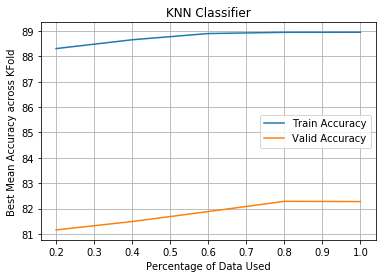

In [172]:
percent_train_acc = [np.array(t_acc).mean(1).max() for t_acc in grow_knn_train_accs.values()]
percent_val_acc = [np.array(v_acc).mean(1).max() for v_acc in grow_knn_val_accs.values()]
plt.plot(percent_data, percent_train_acc, label="Train Accuracy")
plt.plot(percent_data, percent_val_acc, label="Valid Accuracy")
plt.grid()
plt.xlabel('Percentage of Data Used')
plt.ylabel('Best Mean Accuracy across KFold')
plt.title("KNN Classifier")
plt.legend()
plt.show()

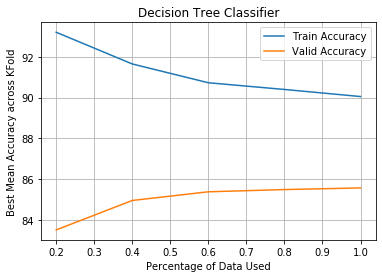

In [176]:
percent_train_acc = [np.array(t_acc).mean(1).max() for t_acc in grow_dt_train_accs.values()]
percent_val_acc = [np.array(v_acc).mean(1).max() for v_acc in grow_dt_val_accs.values()]
plt.plot(percent_data, percent_train_acc, label="Train Accuracy")
plt.plot(percent_data, percent_val_acc, label="Valid Accuracy")
plt.grid()
plt.xlabel('Percentage of Data Used')
plt.ylabel('Best Mean Accuracy across KFold')
plt.legend()
plt.title("Decision Tree Classifier")
plt.show()

#### KNN Parameter Importances

In [220]:
param_combinations = []
for n_neigh in n_neighbors:
    for _p in p:
        knn_kw = {
            'n_neighbors': n_neigh,
            'p': _p,
        }
        param_combinations.append(knn_kw)
n_fold_means = np.array(grow_knn_val_accs['1.0']).mean(1)
sorted_parameters = [param for _, param in sorted(zip(n_fold_means, param_combinations), key=lambda x: x[0], reverse=True)]

In [221]:
sorted_parameters[:10]

[{'n_neighbors': 6, 'p': 1},
 {'n_neighbors': 6, 'p': 2},
 {'n_neighbors': 4, 'p': 1},
 {'n_neighbors': 4, 'p': 2},
 {'n_neighbors': 2, 'p': 1},
 {'n_neighbors': 2, 'p': 2}]

#### Decision Tree Parameter Importances

In [222]:
param_combinations = []
for criteria in criterion:
    for depth in max_depth:
        for mss in min_samples_split:
            dt_kw = {
                'criterion': criteria,
                'max_depth': depth,
                'min_samples_split': mss
            }
            param_combinations.append(dt_kw)
n_fold_means = np.array(grow_dt_val_accs['1.0']).mean(1)
sorted_parameters = [param for _, param in sorted(zip(n_fold_means, param_combinations), key=lambda x: x[0], reverse=True)]

In [223]:
sorted_parameters[:10]

[{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 4},
 {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2},
 {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 6},
 {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 4},
 {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 6},
 {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 4},
 {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2},
 {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 6},
 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2},
 {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}]

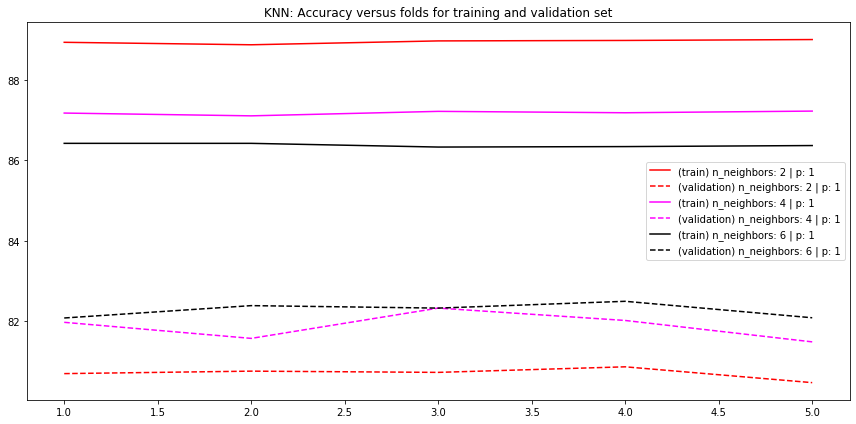

In [109]:
# KNN
import matplotlib.pyplot as plt
colors = ['red', 'magenta', 'black', 'green']

k_indices_p_1_train = [knn_train_accs[0], knn_train_accs[2], knn_train_accs[4]] 
k_indices_p_1_val = [knn_val_accs[0], knn_val_accs[2], knn_val_accs[4]]

k_indices_p_2_train = [knn_train_accs[1], knn_train_accs[3], knn_train_accs[5]] 
k_indices_p_2_val = [knn_val_accs[1], knn_val_accs[3], knn_val_accs[5]]

x = np.arange(1, n_folds+1)

plt.figure(figsize=(12, 6))

for i in range(len(k_indices_p_1_train)):
    n_neigh = n_neighbors[i]
    c = colors[i]
    plt.plot(x, k_indices_p_1_train[i], label='(train) n_neighbors: ' + str(n_neigh) + ' | p: 1', color=c)
    plt.plot(x, k_indices_p_1_val[i], label='(validation) n_neighbors: ' + str(n_neigh) + ' | p: 1', linestyle='dashed', color=c)
        
#     plt.plot(x, k_indices_p_2_train[i], label='(train) n_neighbors: ' + str(n_neigh) + ' | p: 2',)
#     plt.plot(x, k_indices_p_2_val[i], label='(validation) n_neighbors: ' + str(n_neigh) + ' | p: 2')

plt.title("KNN: Accuracy versus folds for training and validation set")
plt.legend()
plt.tight_layout()
plt.show()

#### Comparison of time taken for model to evaluate

In [204]:
from time import time
start = time()
knn_model, one_hot = fit_classifier(cross_X_train, cross_y_train, OneHotEncoder(handle_unknown='ignore'), KNeighborsClassifier, **knn_kw)
val_acc = eval_classifier(cross_X_val, cross_y_val, one_hot, knn_model)
knn_time = time() - start
print(f"Time to train and evaluate KNN Classifiers: {knn_time:2f}s")

start = time()
dt_model, one_hot = fit_classifier(cross_X_train, cross_y_train, OneHotEncoder(handle_unknown='ignore'), DecisionTreeClassifier, **dt_kw)
val_acc = eval_classifier(cross_X_val, cross_y_val, one_hot, dt_model)
dt_time = (time() - start)
print(f"Time to train and evaluate Decision Tree Classifiers: {dt_time:.2f}s")

print(f"KNN is {(knn_time/dt_time):.2f} times slower than Decision Trees")

Time to train and evaluate KNN Classifiers: 8.644178s
Time to train and evaluate Decision Tree Classifiers: 0.80s
KNN is 10.79 times slower than Decision Trees
